In [107]:
!pip3 install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


/var/folders/t5/mxgw5t8j2236t033_3djvdgh0000gn/T/ipykernel_1253/4220609693.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


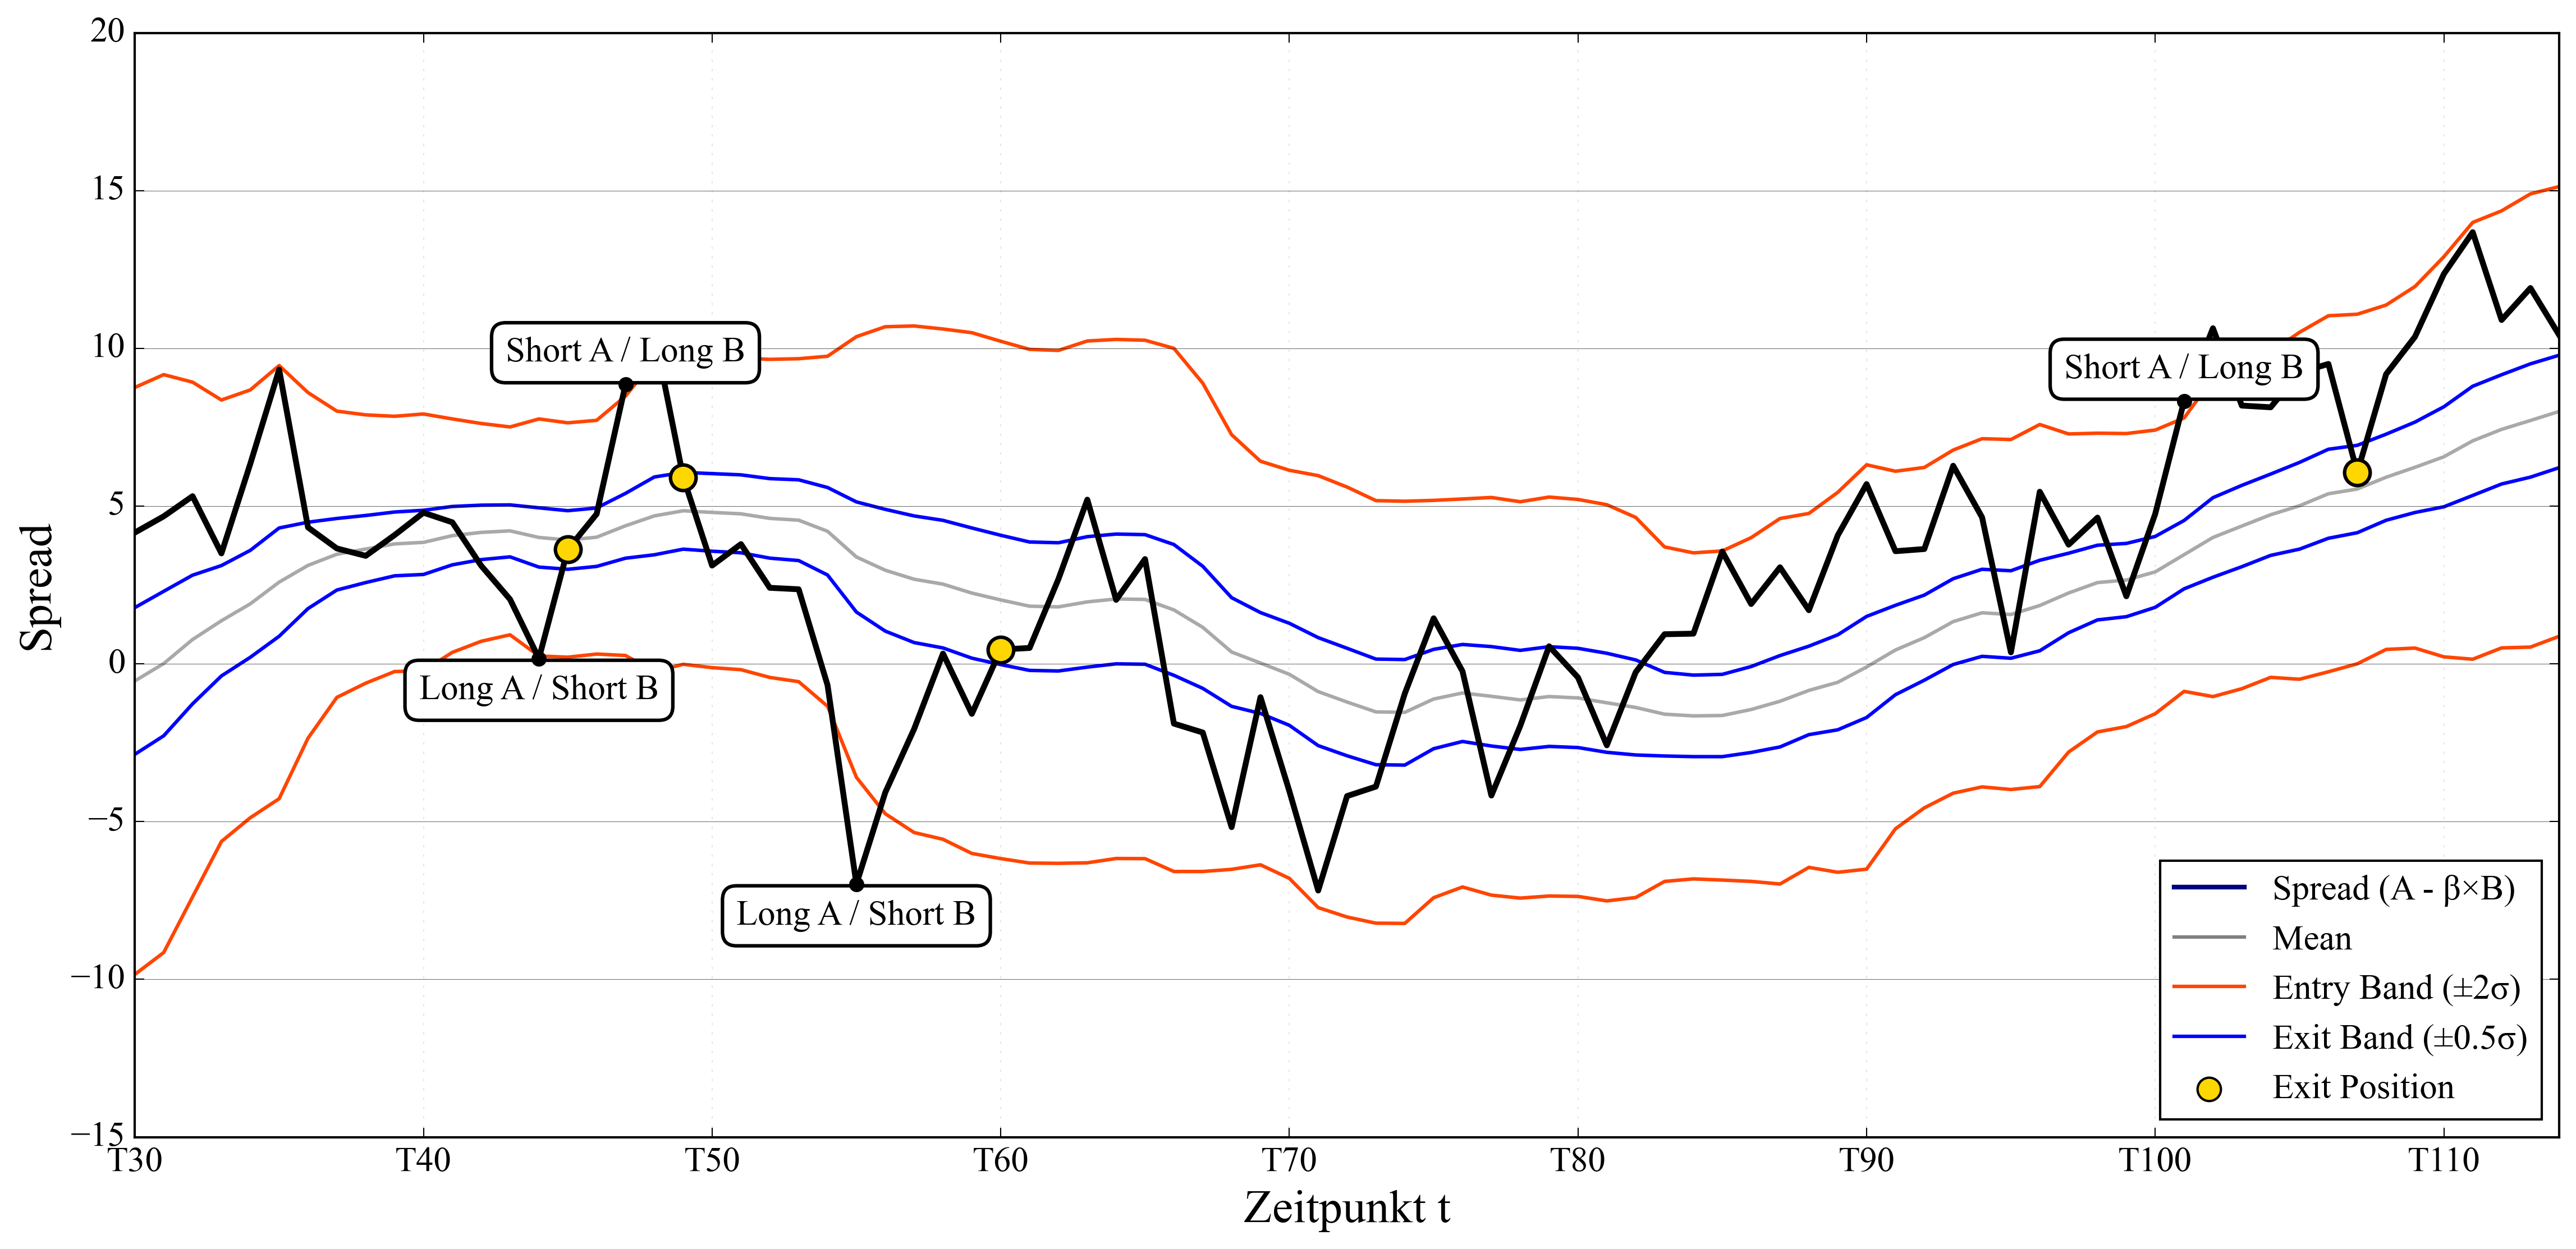

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

random.seed(42)
np.random.seed(42)

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'Liberation Serif', 'Nimbus Roman No9 L'],
    'font.size': 12,
    'axes.labelsize': 18,  # Increased from 14 to 18
    'axes.titlesize': 16,
    'xtick.labelsize': 15,  # Increased from 13 to 15
    'ytick.labelsize': 15,  # Increased from 13 to 15
    'legend.fontsize': 15,
    'text.usetex': False,
    'figure.figsize': (12, 5),
    'axes.grid': True,
    'grid.alpha': 0.1,  # Increased from 0.3 to 0.5 for better visibility
    'lines.linewidth': 1.5,
    'axes.facecolor': 'white',  # Set plot background to white
    'figure.facecolor': 'white',  # Set figure background to white
})

def generate_cointegrated_data(days=365):
    base_date = datetime(2023, 1, 1)
    dates = [base_date + timedelta(days=i) for i in range(days)]
    
    common_trend = np.cumsum(np.random.normal(0.0005, 0.005, days))
    
    noise1 = np.random.normal(0, 0.01, days)
    noise2 = np.random.normal(0, 0.01, days)
    
    spread = np.zeros(days)
    spread[0] = 0
    mean_reversion_strength = 0.05
    spread_volatility = 0.02
    
    for i in range(1, days):
        spread[i] = spread[i-1] - mean_reversion_strength * spread[i-1] + np.random.normal(0, spread_volatility)
    
    price1 = 100 * np.exp(common_trend + noise1)
    price2 = 90 * np.exp(common_trend + noise2 + spread)
    
    df = pd.DataFrame({
        'date': dates,
        'price1': price1,
        'price2': price2,
    })
    df.set_index('date', inplace=True)
    
    return df

def calculate_hedge_ratio_and_spread(df, window_size=20):
    model = sm.OLS(df['price1'], df['price2']).fit()
    hedge_ratio = model.params[0]
    
    df['spread'] = df['price1'] - df['price2'] * hedge_ratio
    
    df['rolling_mean'] = df['spread'].rolling(window=window_size).mean()
    df['rolling_std'] = df['spread'].rolling(window=window_size).std()
    
    std_dev = 2.0
    exit_std_dev = 0.5
    df['upper_band'] = df['rolling_mean'] + (df['rolling_std'] * std_dev)
    df['lower_band'] = df['rolling_mean'] - (df['rolling_std'] * std_dev)
    df['exit_upper'] = df['rolling_mean'] + (df['rolling_std'] * exit_std_dev)
    df['exit_lower'] = df['rolling_mean'] - (df['rolling_std'] * exit_std_dev)
    
    return df, hedge_ratio

def simulate_coint_trades(df, entry_std=2.0, exit_std=0.5):
    trades = []
    positions = []
    
    in_position = False
    position_type = None
    entry_date = None
    entry_index = None
    
    for i in range(20, len(df)):
        curr_spread = df['spread'].iloc[i]
        curr_mean = df['rolling_mean'].iloc[i]
        curr_std = df['rolling_std'].iloc[i]
        curr_date = df.index[i]
        
        upper_band = curr_mean + (curr_std * entry_std)
        lower_band = curr_mean - (curr_std * entry_std)
        exit_upper = curr_mean + (curr_std * exit_std)
        exit_lower = curr_mean - (curr_std * exit_std)
        
        if not in_position:
            if curr_spread > upper_band:
                in_position = True
                position_type = 'short-long'
                entry_date = curr_date
                entry_index = i
                trades.append({
                    'type': 'entry',
                    'position': position_type,
                    'date': curr_date,
                    'spread': curr_spread,
                    'upper_band': upper_band,
                    'lower_band': lower_band,
                    'price1': df['price1'].iloc[i],
                    'price2': df['price2'].iloc[i]
                })
                positions.append({
                    'date': curr_date,
                    'position': -1,
                    'active': True
                })
            
            elif curr_spread < lower_band:
                in_position = True
                position_type = 'long-short'
                entry_date = curr_date
                entry_index = i
                trades.append({
                    'type': 'entry',
                    'position': position_type,
                    'date': curr_date,
                    'spread': curr_spread,
                    'upper_band': upper_band,
                    'lower_band': lower_band,
                    'price1': df['price1'].iloc[i],
                    'price2': df['price2'].iloc[i]
                })
                positions.append({
                    'date': curr_date,
                    'position': 1,
                    'active': True
                })
        
        elif in_position:
            if (position_type == 'short-long' and curr_spread < exit_upper) or \
               (position_type == 'long-short' and curr_spread > exit_lower):
                trades.append({
                    'type': 'exit',
                    'position': position_type,
                    'date': curr_date,
                    'spread': curr_spread,
                    'entry_date': entry_date,
                    'days_held': (curr_date - entry_date).days,
                    'price1': df['price1'].iloc[i],
                    'price2': df['price2'].iloc[i],
                    'price1_entry': df['price1'].iloc[entry_index],
                    'price2_entry': df['price2'].iloc[entry_index]
                })
                for pos in positions:
                    if pos['date'] == entry_date:
                        pos['active'] = False
                        pos['exit_date'] = curr_date
                
                in_position = False
                position_type = None
    
    return trades, positions

def create_bollinger_visualization():
    # Reduzierte Zeitspanne: nur 135 Tage statt 365
    days = 135
    df = generate_cointegrated_data(days)
    
    df['norm_price1'] = df['price1'] / df['price1'].iloc[0]
    df['norm_price2'] = df['price2'] / df['price2'].iloc[0]
    
    window_size = 20
    df, hedge_ratio = calculate_hedge_ratio_and_spread(df, window_size=window_size)
    
    trades, positions = simulate_coint_trades(df, entry_std=2.0, exit_std=0.5)
    
    # Schneide die ersten window_size Tage ab, wo keine Bollinger-Bänder existieren
    df_plot = df.iloc[window_size:].copy()
    
    # Erstelle abstrakte Zeitachse (T0, T10, usw.)
    time_points = np.arange(len(df_plot))
    df_plot['time_index'] = time_points
    
    # Schneide die ersten 30 Datenpunkte ab (bis T30)
    cutoff_index = 30  # T30
    df_plot = df_plot.iloc[cutoff_index:].copy()
    # Reset time_index to start from 0 after cutting off data
    df_plot['time_index'] = np.arange(len(df_plot))
    
    # Größere Figurengröße für bessere Lesbarkeit
    plt.figure(figsize=(16, 8))
    
    # Reduziere die Ränder (Padding)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.1)
    
    # Set plot background to white
    ax = plt.gca()
    ax.set_facecolor('white')
    
    # Set grid properties
    plt.grid(True, axis='y', linestyle='-', linewidth=0.2, alpha=0.7)
    
    plt.plot(df_plot['time_index'], df_plot['rolling_mean'], label='Mean', color='darkgrey', linestyle='-', linewidth=1.5)
    plt.plot(df_plot['time_index'], df_plot['upper_band'], label='Upper Band (Entry)', color='orangered', linestyle='-', linewidth=1.5)
    plt.plot(df_plot['time_index'], df_plot['lower_band'], label='Lower Band (Entry)', color='orangered', linestyle='-', linewidth=1.5)
    plt.plot(df_plot['time_index'], df_plot['exit_upper'], label='Upper Band (Exit)', color='blue', linestyle='-', linewidth=1.5)
    plt.plot(df_plot['time_index'], df_plot['exit_lower'], label='Lower Band (Exit)', color='blue', linestyle='-', linewidth=1.5)
    plt.plot(df_plot['time_index'], df_plot['spread'], label='Spread (A - β×B)', color='black', linewidth=2.5)
    
    # Plot entry and exit points mit größeren Markern
    # Ignoriere den letzten Trade, der möglicherweise abgeschnitten wird
    max_time = max(df_plot['time_index']) - 5  # 5 Zeitpunkte Puffer zum Rand
    
    # Filter trades to only include those after the cutoff
    cutoff_date = df_plot.index[0]  # First date in the filtered df
    
    for trade in trades:
        # Nur Trades nach dem Cutoff berücksichtigen
        if trade['date'] >= cutoff_date and trade['date'] in df_plot.index:
            time_idx = df_plot.loc[df_plot.index == trade['date'], 'time_index'].values[0]
            
            # Überspringe Trades, die zu nahe am Rand sind
            if time_idx > max_time:
                continue
                
            if trade['type'] == 'entry':
                # Positionsmarkierung durch Textbox mit schwarzem Rahmen
                if trade['position'] == 'short-long':
                    text_label = "Short A / Long B"
                    # Erstelle einen schwarzen Rand um den Text mit mehr Padding
                    bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1.5)
                    # Extrem viel Abstand zwischen Punkt und Text (0.5 statt 0.25)
                    y_offset = trade['spread'] + 0.5
                    plt.text(time_idx, y_offset, text_label, 
                            ha='center', va='bottom', fontsize=15, fontweight='normal',
                            bbox=bbox_props)
                    # Einfacher schwarzer Punkt zur Markierung der Position
                    plt.scatter(time_idx, trade['spread'], marker='o', color='black', s=30, zorder=5)
                else:
                    text_label = "Long A / Short B"
                    # Erstelle einen schwarzen Rand um den Text mit mehr Padding
                    bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1.5)
                    # Extrem viel Abstand zwischen Punkt und Text (0.5 statt 0.25)
                    y_offset = trade['spread'] - 0.5
                    plt.text(time_idx, y_offset, text_label, 
                            ha='center', va='top', fontsize=15, fontweight='normal',
                            bbox=bbox_props)
                    # Einfacher schwarzer Punkt zur Markierung der Position
                    plt.scatter(time_idx, trade['spread'], marker='o', color='black', s=30, zorder=5)
            else:
                # Circle für Exit Position behalten (ohne Label)
                plt.scatter(time_idx, trade['spread'], marker='o', color='gold', s=120, zorder=5, 
                          edgecolors='black', linewidths=1.5)
    
    plt.ylabel('Spread', fontsize=20)  # Increased size without bold
    plt.xlabel('Zeitpunkt t', fontsize=20)  # Increased size without bold
    
    # Anpassen der X-Achsengrenzen direkt auf den Datenbereich ohne Ränder
    plt.xlim(0, max(df_plot['time_index']))
    
    # Erstelle wissenschaftliche X-Achsenbeschriftung
    # Start from T30 (since we cut off the data)
    x_ticks = np.arange(0, len(df_plot), 10)  # Alle 10 Zeitpunkte
    x_labels = []
    for i in range(len(x_ticks)):
        x_labels.append(f"T{x_ticks[i] + cutoff_index}")  # Adjust labels to start from T30
    
    plt.xticks(x_ticks, x_labels)
    
    # Vereinfachte Legende ohne Entry Position
    custom_handles = [
        Line2D([0], [0], color='navy', linewidth=2.0),
        Line2D([0], [0], color='grey', linestyle='-', linewidth=1.5),
        Line2D([0], [0], color='orangered', linestyle='-', linewidth=1.5),
        Line2D([0], [0], color='blue', linestyle='-', linewidth=1.5),
        # Nur Exit Position in der Legende
        plt.scatter([], [], color='gold', marker='o', s=100, edgecolors='black', linewidths=1.0)
    ]

    custom_labels = [
        'Spread (A - β×B)',
        'Mean',
        'Entry Band (±2σ)',
        'Exit Band (±0.5σ)',
        'Exit Position'
    ]

    # Optimierte Legende-Einstellungen für saubere Darstellung
    plt.legend(handles=custom_handles, labels=custom_labels, loc='lower right', 
               fontsize=15, 
              handlelength=2.0, numpoints=1, scatterpoints=1)
    
    
    # Show the figure on the console instead of saving to file
    plt.show()

if __name__ == "__main__":
    create_bollinger_visualization()